In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l

# 注意力汇聚: Nadaraya-Watson核回归
查询(自主提示)和键(非自主提示)之间交互形成了注意力汇聚, 注意力汇聚有选择性地聚合了值(感官输入)以生成最终的输出

## 生成数据集
考虑如下回归问题, 给定的成对的输入-输出数据集 $\{(x_1, y_1), \ldots, (x_n, y_n)\}$, 通过学习 $f$来预测任意新输入$x$ 的输出$\hat{y} = f(x)$

利用如下非线性函数生成一个人工数据集, 加入噪声项为 $\epsilon$:
$$
y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon
$$

In [2]:
# 数据集
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train)*5)

def f(x):
    return 2 * torch.sin(x) + x**0.8
y_train = f(x_train) + torch.normal(0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本对应标签
n_test = len(x_test)
n_test

50

In [3]:
# 绘制测试集\训练集图图像
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
            xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

## 平均汇聚
可以使用最简单的估计器来解决这一个回归问题, 可以基于平均汇聚来计算所由样本输出值的平均值
$$
f(x) = \frac{1}{n} \sum_{i=1}^n y_i
$$

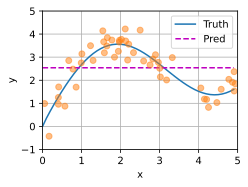

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数注意力汇聚
平均汇聚层只考虑了 $y_i$, 没有考虑输入 $x_i$, 如下算法可以根据输入的位置对于输出$y_i$进行加权:
$$
f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i
$$
其中 $K$ 是核, 上述公式描述的估计器为 `Nadaraya-Watson`核回归, 其实就是考虑了训练集中每一个样本对于最终输出的影响, 可以从注意力框架的角度重写, 成为一个更加通用的注意力汇聚公式:
$$
f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i
$$
其中 $x$ 为查询, $(x_i, y_i)$ 为键值对, 注意力汇聚是 $y_i$ 的加权平均, 将查询$x$ 和键 $x_i$ 之间的关系建模成 **注意力权重 $\alpha(x, x_i)$**, 这个权重被分配给每一个对应值 $y_i$, 并且对于任何查询, 模型在所有键值对注意力权重是一个有小的概率分布(非负、归一)

可以考虑一个高斯核:
$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp({-\frac{u^2}{2}})
$$
将高斯核带入, 可以得到:
$$
\begin{aligned}
f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\
&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\
&= \sum_{i=1}^n \text{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i.
\end{aligned}
$$
这里我对于核公式 $f(x) = \sum_{i=1}^{n} \alpha(x, x_i)y_i$ 的理解: 其中 $x$ 可以表示查询(`Q`), $x_i$ 表示键 $K$, $y_i$ 表示值 $V$, 这里的注意力权重作为值的权重, 并且输出就是值的权重和, 同时注意力权重取决于(`Q, K`)

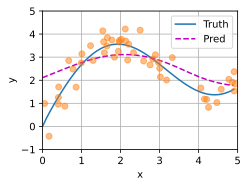

In [5]:
# 使用非参数的注意力汇聚模型
# X_repeat.shape -> (n_test, n_train)
# 每一行都包含相同的测试输入(表示相同的查询)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# X_train 包含这键, attention_weights.shape -> (n_test, n_train)
# 每一行都包含着在给定的每一个查询的值 (y_train) 之间分配的注意力机制
attention_weights = F.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
# y_hat 就是每一个值的加权平均值, 并且这里的权重就是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

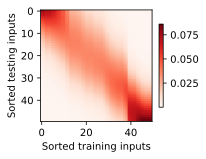

In [6]:
# 观察此时的注意力权重
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), # 添加维度
                 xlabel='Sorted training inputs',
                 ylabel='Sorted testing inputs')

## 带参数注意力汇聚
非参数的核回归具有一致性: 如果由足够的数据, 可以收敛到最优结果, 下面考虑将可学习的参数集成到注意力汇聚中

可以在查询$x$和键$x_i$之间的举例乘以可学习参数$w$:
$$
\begin{align}
f(x) &= \sum_{i=1}^{n} \alpha(x, x_i) y_i \notag \\
     &= \sum_{i=1}^{n} \frac{\exp\left(-\frac{1}{2} \left((x - x_i) w\right)^2\right)}{\sum_{j=1}^{n} \exp\left(-\frac{1}{2} \left((x - x_j) w\right)^2\right)} y_i \notag \\
     &= \sum_{i=1}^{n} \text{softmax}\left(-\frac{1}{2} \left((x - x_i) w\right)^2\right) y_i.
\end{align}
$$

### 批量矩阵乘法
**批量矩阵乘法**: 假设第一个小批量数据包括$n$个矩阵$\mathbf{X}_1, \ldots, \mathbf{X}_n$, 形状为 $a \times b$, 第二个小批量包括$n$个矩阵 $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$, 形状为 $b \times c$, 那么它们的批量矩阵乘法为 $\mathbf{X_1}\mathbf{Y_1}, \ldots, \mathbf{X_n}\mathbf{Y_n}$, 形状为 $a \times c$, 因此两个张量的形状分别为 $(n, a, b)$ 和 $(n, b, c)$, 批量矩阵乘法输出形状为$(n, a, c)$

In [7]:
# 批量矩阵乘法
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
# 在注意力机制的背景中, 可以使用小批量矩阵乘法来计算小批量数据的加权平均值
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
# weights -> (2, 1, 10), values -> (2, 10, 1)
outputs = torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))
outputs, outputs.shape

(tensor([[[ 4.5000]],
 
         [[14.5000]]]),
 torch.Size([2, 1, 1]))

### 定义模型
下面实现带参数的注意力汇聚, 使用小批量矩阵乘法

In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1,), requires_grad=True)
    def forward(self, queries, keys, values):
        # queries, attention_weights 形状 (查询个数, K-V对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = F.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1
        )
        # values 形状 (查询个数, K-V个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                        values.unsqueeze(-1)).reshape(-1)

## 模型训练

In [10]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1) 减少了对角线元素
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

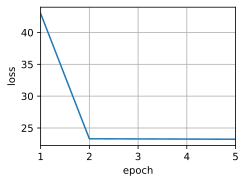

In [11]:
# 模型训练
net = NWKernelRegression() # 核回归模型
loss = nn.MSELoss(reduction='none') # 平方损失函数
trainer = torch.optim.SGD(net.parameters(), lr=0.5) # SGD 作为优化器
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5]) # 绘图

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

## 测试

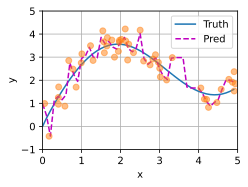

In [12]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

可以发现此时新的模型不够平滑, 可以发现与非参数的注意力汇聚模型相比, 带参数的模型加入可学习的参数之后, 曲线在注意力权重较大的区域变得不平滑

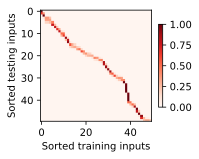

In [13]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 注意力汇聚总结
### 计算过程
首先 `keys` 矩阵如下:
$$
K = \begin{bmatrix}
x_2 & x_3 & \ldots & x_{50} \\
x_1 & x_3 & \ldots & x_{50} \\
\vdots & \vdots & \ddots & \vdots \\
x_1 & x_2 & \ldots & x_{49}
\end{bmatrix}
$$
`values` 矩阵为:
$$
K = \begin{bmatrix}
y_2 & y_3 & \ldots & y_{50} \\
y_1 & y_3 & \ldots & y_{50} \\
\vdots & \vdots & \ddots & \vdots \\
y_1 & y_2 & \ldots & y_{49}
\end{bmatrix}
$$
所以对于模型前向传播的过程, 输入 $X_{train} = [x_1, x_2, \ldots , x_{50}]$, 经过拓展之后, 相当于沿着列的方向拓展了, 形状为 $n \times n - 1$($n$ 为训练集大小), 注意力权重矩阵为:
$$
Attention = \begin{bmatrix}
\alpha(x_1,x_2) & \alpha(x_1,x_3) & \ldots & \alpha(x_1,x_{50}) \\
\alpha(x_2,x_1) & \alpha(x_2,x_3) & \ldots & \alpha(x_2,x_{50}) \\
\vdots & \vdots & \ddots & \vdots \\
\alpha(x_{50},x_1) & \alpha(x_{50}, x_2) & \ldots & \alpha(x_{50},x_{49})
\end{bmatrix}
$$
经过批量乘法, 可以得到最终输出大小为 $n \times 1$, 输出中的第 $i$ 行如下:
$$
output[i] = \sum_{j \neq i}^{n} \alpha(x_i, x_j) y_j
$$
### 注意力本质
注意对于一个平滑的目标函数, 对于其中的一个样本点 $x_i$ 对应的标签值 $y_i$, 我们可以发现和 $x_i$ 关联性最大的就是 $x_i$ 旁边的点, 但是距离较远的点对于 $x_i$ 的影响小, 所以对应的 $y$ 对于 $x_i$ 的注意力权重 $\alpha(x_i, x_j)$ 比较小

`Q` 的作用: 作为输入值, 根据 `K` 计算出注意力权重, 在根据 `V` 得到输出
`K, V` 的作用: 记录已经存在的数据的映射关系, 后面考虑注意力权重之后就可以对应 `Q` 的输入